In [197]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    os.chdir(os.path.dirname(os.getcwdb()))


In [198]:
import pandas as pd
import numpy as np
from copy import copy
import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score

from xgboost import XGBRegressor



class Model:


    def __init__(self, df, target_name, index=None):
        self.target_name = target_name
        self.index = index
        self.df = df


    @property
    def dataframe(self):
        if self.index:
            return self.df.set_index(self.index)
        else:
            return self.df


    @staticmethod
    def send_pickle():
        pass


    def split_dataframe(self, train_num=0.7, random_num=43, scaler=None, return_entire_Xy=False):
        self.random_num = random_num
        X = self.dataframe.drop(columns=self.target_name)
        y = self.dataframe[self.target_name]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, train_size=train_num, random_state=self.random_num)
        if scaler:
            self.scaler = eval(scaler + '()')
            self.scaler_name = ' (' + scaler + ')'
            self.X_train = self.scaler.fit_transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)        
            if return_entire_Xy:
                self.scaler = eval(scaler + '()')
                X = self.scaler.fit_transform(X)
        else:
            self.scaler_name = ''
        if return_entire_Xy:
            return (X, y)
        else:
            return (self.X_train, self.X_test, self.y_train, self.y_test)


    def prepare_models(self, selected_list=None, excluded_list=None, params_list=None):
        self.models = self.chosen_models.copy()
        if not excluded_list:
            excluded_list = []
        if not selected_list:
            selected_list = []
        self.models_previous = self.models.copy()
        for element in self.models_previous.keys():
            if (len(selected_list) >= 1 and element not in selected_list) or element in excluded_list:
                self.models.pop(element)
        for model_name in self.models.keys():
            self.models[model_name] = eval(model_name + '()')
        if params_list:
            for params in params_list:
                self.models[params[0] + ': ' + params[1]] = eval(params[0] + '(' + params[1] + ')')
            for params in params_list:
                    if params[0] in self.models:
                        try:
                            self.models.pop(params[0])
                        except Exception:
                            continue
        return 'Models prepared. Apply them or use kfold (apply + evaluate)'


    def apply_models(self):
        print(f'-- {self.type.capitalize()} --')
        current_time = time.time()
        total_time = time.time() - current_time
        for model_name, model in self.models.items():
            start_time = time.time()
            print(f'Starting {model_name}:')
            model.fit(self.X_train, self.y_train)
            self.y_pred = model.predict(self.X_test)
            self.models[model_name] = {'test': np.array(self.y_test), 'prediction': self.y_pred, 'model': model}
            execution_time = time.time() - start_time
            total_time += execution_time
            print(f'- {model_name} done in {round(execution_time, 2)} sec(s). Total time: {round(total_time, 2)}')
        return self.models


    def create_dataframe(self, best_values_list, worst_values_list):
        self.df = pd.DataFrame(data=self.models_metrics)
        if best_values_list:
            best_values_list = [element[0] for element in best_values_list]
            worst_values_list = [element[0] for element in worst_values_list]
            self.df['BEST'] = best_values_list
            self.df['WORST'] = worst_values_list


    def visualize(self, metrics_selection=None):
        visualization_dict = {'models': [model_name for model_name in self.models_metrics.keys() for metric in self.models_metrics[model_name] if (not metrics_selection or metric in metrics_selection)],
                              'metrics': [metric for model_name in self.models_metrics.keys() for metric in self.models_metrics[model_name] if (not metrics_selection or metric in metrics_selection)],
                              'values': [self.models_metrics[model_name][metric] for model_name in self.models_metrics.keys() for metric in self.models_metrics[model_name] if (not metrics_selection or metric in metrics_selection)]
                              }
        sns.lineplot(data=visualization_dict, x='models', y='values', hue='metrics')
        plt.tick_params(axis='x', labelrotation = 30)
        plt.title('Medicine price by date')
        plt.show()



class Regression(Model):
    chosen_models = dict()


    def __init__(self, dataframe, target_name, index=None):
        super().__init__(dataframe, target_name, index)
        self.type = 'regression'


    @classmethod
    def add_models(cls, regression_list):
        if regression_list:
            for element in regression_list:
                cls.chosen_models[element] = ''


    @classmethod
    def remove_models(cls, regression_list):
        if regression_list:
            for element in regression_list:
                cls.chosen_models.pop(element)

  
    def apply_and_evaluate_kfolds(self, kfolds_num=5):
        self.kfolds_num = kfolds_num
        self.kfolds = KFold(n_splits=kfolds_num, shuffle=True, random_state=self.random_num)
        self.kfold = 'fold'
        metrics = ['neg_root_mean_squared_error', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2', 'neg_mean_absolute_percentage_error']
        self.models_evaluated = dict()
        print(f'-- {self.type.capitalize()}{self.scaler_name}: using mean of {self.kfolds_num} {self.kfold}s --')
        current_time = time.time()
        total_time = time.time() - current_time
        for model_name, model in self.models.items():
            print(f'Starting {model_name}:')
            start_time = time.time()
            cross_val = cross_validate(model, self.X_train, self.y_train, cv=self.kfolds, return_estimator=True, scoring=metrics)
            list_of_metrics = list(cross_val.keys())[3:]
            self.models_evaluated[model_name] = dict()
            self.models_evaluated[model_name]['models'] = cross_val['estimator']
            self.models_evaluated[model_name]['metrics'] = {'rmse': abs(np.mean(list(cross_val.values())[3:][0])), 
                                                            'mse': abs(np.mean(list(cross_val.values())[3:][1])), 
                                                            'mae': abs(np.mean(list(cross_val.values())[3:][2])), 
                                                            'r2_score': np.mean(list(cross_val.values())[3:][3]), 
                                                            'mape': abs(np.mean(list(cross_val.values())[3:][4]))}
            self.models_evaluated[model_name]['all_metrics'] = {'rmse': list(map(abs, list(cross_val.values())[3:][0])), 
                                                            'mse': list(map(abs, list(cross_val.values())[3:][1])), 
                                                            'mae': list(map(abs, list(cross_val.values())[3:][2])), 
                                                            'r2_score': list(map(abs, list(cross_val.values())[3:][3])), 
                                                            'mape': list(map(abs, list(cross_val.values())[3:][4]))}
            self.models_evaluated[model_name]['variances'] = {'rmse': np.var(list(cross_val.values())[3:][0]), 
                                                            'mse': np.var(list(cross_val.values())[3:][1]), 
                                                            'mae': np.var(list(cross_val.values())[3:][2]), 
                                                            'r2_score': np.var(list(cross_val.values())[3:][3]), 
                                                            'mape': np.var(list(cross_val.values())[3:][4])}
            execution_time = time.time() - start_time
            total_time += execution_time
            print(f'- {model_name} done in {round(execution_time, 2)} sec(s). Total time: {round(total_time, 2)}')
        return self.models_evaluated


    def evaluate_metrics(self):
        self.models_evaluated = self.models.copy()
        for model_name, model_results in self.models_evaluated.items():
            rmse = mean_squared_error(model_results['test'], model_results['prediction'], squared=False)
            mse = mean_squared_error(model_results['test'], model_results['prediction'])
            mae = mean_absolute_error(model_results['test'], model_results['prediction'])
            r2 = r2_score(model_results['test'], model_results['prediction'])
            mape = mean_absolute_percentage_error(model_results['test'], model_results['prediction'])
            self.models_evaluated[model_name]['metrics'] = {'rmse': rmse, 'mse': mse, 'mae': mae, 'r2_score': r2, 'mape': mape}
        return self.models_evaluated


    def create_dataframe(self, chosen_metric='mean'):
        self.models_metrics = self.models_evaluated.copy()
        best_values_list = []
        worst_values_list = []
        if chosen_metric == 'mean':
            chosen_metric = 'metrics'
        for model_name, model_results in self.models_evaluated.items():
            self.models_metrics[model_name] = self.models_metrics[model_name][chosen_metric]
            if len(self.models_metrics) > 1:
                model_values = [value if type(value) is not list else sum([row[index] for index, row in enumerate(value)]) for value in self.models_evaluated[model_name][chosen_metric].values()]
                if not best_values_list:
                    best_values_list = [[model_name, value] for value in model_values]
                    worst_values_list = [[model_name, value] for value in model_values]
                else:
                    for index, value in enumerate(model_values):
                        if value < best_values_list[index][1]:
                            if index != 3:
                                best_values_list[index][1] = value
                                best_values_list[index][0] = model_name
                            else:
                                worst_values_list[index][1] = value
                                worst_values_list[index][0] = model_name
                        if value > worst_values_list[index][1]:
                            if index != 3:
                                worst_values_list[index][1] = value
                                worst_values_list[index][0] = model_name
                            else:
                                best_values_list[index][1] = value
                                best_values_list[index][0] = model_name
        super().create_dataframe(best_values_list, worst_values_list)
        return self.df



class Classification(Model):
    chosen_models = dict()


    def __init__(self, dataframe, target_name, index=None):
        super().__init__(dataframe, target_name, index)
        self.type = 'classification'


    @classmethod
    def add_models(cls, classification_list):
        if classification_list:
            for element in classification_list:
                cls.chosen_models[element] = ''


    @classmethod
    def remove_models(cls, classification_list):
        if classification_list:
            for element in classification_list:
                cls.chosen_models.pop(element)


    def apply_and_evaluate_kfolds(self, kfolds_num=5, multiclass_average=None):
        self.kfolds = StratifiedKFold(n_splits=kfolds_num, shuffle=True, random_state=self.random_num)
        self.kfolds_num = kfolds_num
        self.kfold = 'stratified fold'
        metrics = ['accuracy', 'recall', 'precision', 'f1']
        if multiclass_average == 'micro':
            metrics = ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro'] 
        elif multiclass_average == 'macro':
            metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'] 
        elif multiclass_average == 'samples':
            metrics = ['accuracy', 'precision_samples', 'recall_samples', 'f1_samples'] 
        elif multiclass_average == 'weighted':
            metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'] 
        self.models_evaluated = dict()
        print(f'-- {self.type.capitalize()}{self.scaler_name}: using mean of {self.kfolds_num} {self.kfold}s --')
        current_time = time.time()
        total_time = time.time() - current_time
        for model_name, model in self.models.items():
            print(f'Starting {model_name}:')
            start_time = time.time()
            cross_val = cross_validate(model, self.X_train, self.y_train, cv=self.kfolds, return_estimator=True, scoring=metrics)
            self.models_evaluated[model_name] = dict()
            self.models_evaluated[model_name]['models'] = cross_val['estimator']
            self.models_evaluated[model_name]['metrics'] = {'accuracy': abs(np.mean(list(cross_val.values())[3:][0])), 
                                                            'recall': abs(np.mean(list(cross_val.values())[3:][1])), 
                                                            'precision': abs(np.mean(list(cross_val.values())[3:][2])), 
                                                            'f1_score': np.mean(list(cross_val.values())[3:][3])}
            self.models_evaluated[model_name]['all_metrics'] = {'accuracy': list(map(abs, list(cross_val.values())[3:][0])), 
                                                            'recall': list(map(abs, list(cross_val.values())[3:][1])), 
                                                            'precision': list(map(abs, list(cross_val.values())[3:][2])), 
                                                            'f1_score': list(map(abs, list(cross_val.values())[3:][3]))}
            self.models_evaluated[model_name]['variances'] = {'accuracy': np.var(list(cross_val.values())[3:][0]), 
                                                            'recall': np.var(list(cross_val.values())[3:][1]), 
                                                            'precision': np.var(list(cross_val.values())[3:][2]), 
                                                            'f1_score': np.var(list(cross_val.values())[3:][3])}
            execution_time = time.time() - start_time
            total_time += execution_time
            print(f'- {model_name} done in {round(execution_time, 2)} sec(s). Total time: {round(total_time, 2)}')
        return self.models_evaluated


    def evaluate_metrics(self, params_list=None):
        self.models_evaluated = self.models.copy()
        for model_name, model_results in self.models_evaluated.items():
            accuracy = "accuracy_score (model_results['test'], model_results['prediction']"
            recall = "recall_score (model_results['test'], model_results['prediction']"
            precision = "precision_score (model_results['test'], model_results['prediction']"
            f1 = "f1_score (model_results['test'], model_results['prediction']"
            matrix = "confusion_matrix (model_results['test'], model_results['prediction']"
            list_of_metrics = []
            for index, element in enumerate([accuracy, recall, precision, f1, matrix], 1):
                if params_list:
                    for params in params_list:
                        if params[0] == element.split()[0]:
                            element += ', ' + params[1] + ')'
                if element[-1] == ']':
                    element += ')'
                list_of_metrics.append(eval(element))
            print(list_of_metrics)
            confusion = [element for element in list_of_metrics[-1]]
            self.models_evaluated[model_name]['metrics'] = {'accuracy': list_of_metrics[0], 'recall': list_of_metrics[1], 'precision': list_of_metrics[2], 'f1_score': list_of_metrics[3], 'confusion_matrix': confusion}
        return self.models_evaluated


    def create_dataframe(self, chosen_metric='mean'):
        self.models_metrics = self.models_evaluated.copy()
        best_values_list = []
        worst_values_list = []
        if chosen_metric == 'mean':
            chosen_metric = 'metrics'
        for model_name, model_results in self.models_evaluated.items():
            self.models_metrics[model_name] = self.models_metrics[model_name][chosen_metric]
            if len(self.models_metrics) > 1:
                model_values = [value if type(value) is not list else sum([row[index] for index, row in enumerate(value)]) for value in self.models_evaluated[model_name][chosen_metric].values()]
                if not best_values_list:
                    best_values_list = [[model_name, value] for value in model_values]
                    worst_values_list = [[model_name, value] for value in model_values]
                else:
                    for index, value in enumerate(model_values):
                        if value > best_values_list[index][1]:
                            best_values_list[index][1] = value
                            best_values_list[index][0] = model_name
                        if value < worst_values_list[index][1]:
                            worst_values_list[index][1] = value
                            worst_values_list[index][0] = model_name
        super().create_dataframe(best_values_list, worst_values_list)
        return self.df


In [199]:
df_diamonds = pd.read_csv(r'data\processed\diamonds_training.csv', index_col='id')
df_predict = pd.read_csv(r'data\processed\diamonds_testing.csv', index_col='id')


In [200]:
Regression.add_models(['LinearRegression',
                        'Ridge',
                        #'DecisionTreeRegressor',
                        #'KNeighborsRegressor',
                        #'RandomForestRegressor',
                        #'SVR',
                        #'XGBRegressor'
                        ]
                        )


In [201]:
diamonds = Regression(df_diamonds, 'price')
X_train, X_test, y_train, y_test = diamonds.split_dataframe()
diamonds.prepare_models()
diamonds.apply_and_evaluate_kfolds()
diamonds.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.19 sec(s). Total time: 0.19
Starting Ridge:
- Ridge done in 0.09 sec(s). Total time: 0.29


,LinearRegression,Ridge,BEST,WORST
rmse,0.182664,0.182826,LinearRegression,Ridge
mse,0.033669,0.033718,LinearRegression,Ridge
mae,0.118476,0.118554,LinearRegression,Ridge
r2_score,0.967188,0.967141,LinearRegression,Ridge
mape,0.015317,0.015327,LinearRegression,Ridge


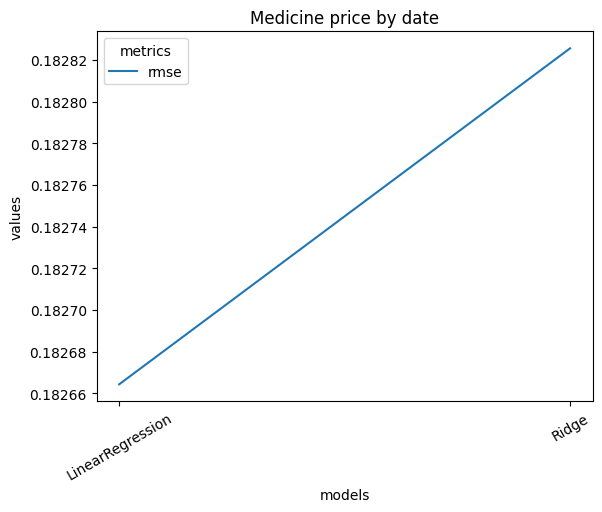

In [205]:
diamonds.visualize(metrics_selection=['rmse'])
